## By: Alex Marzban
**Visit the GitHub repository to access the code for this assignment:** [https://github.com/marzbana/CS521_HWs/tree/main/hw2](https://github.com/marzbana/CS521_HWs/tree/main/hw2)

There is a code folder as well as code in a jupyter notebook to view.


In [1]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath('__file__'))

code_dir = os.path.join(current_dir, 'code')

if code_dir not in sys.path:
    sys.path.append(code_dir)


## Problem 1: MILP Encoding for Maxpool

In the lecture, we learned about the Mixed Integer Linear Programming (MILP) based encoding of the ReLU operation. In this exercise, your goal is to design an encoding of the Maxpool operation using MILP.

### (a)
Design a MILP encoding for the Maxpool operation:

$$
y := \max(x_1, x_2)
$$

where the input bounds for $x_1$ and $x_2$ are $[a_1, b_1]$ and $[a_2, b_2]$ with $a_1$, $a_2$, $b_1$, $b_2 \in \mathbb{R}$.


#### Answer
$$
y = \max(x_1, x_2)
$$


\begin{align*}
y &\geq x_1 \quad &(1) \\
y &\geq x_2 \quad &(2) \\
y &\leq x_1 + \max(b_1 + b_2) \cdot (1 - a) \quad &(3) \\
y &\leq x_2 + \max(b_1 + b_2) \cdot a \quad &(4) \\
a &\in \{0, 1\} \quad &(5) \\
\end{align*}


### (b)

Now, consider the neural network shown in Fig. 1. The neural network has two inputs ($x_1$, $x_2$) and two outputs ($x_9$, $x_{10}$) neurons and consists of two layers with affine transformations (edges colored blue) and one layer with the maxpool operation (edges colored green). The transformations in the network are given as:


\begin{align*}
x_3 &:= x_1 + x_2 \\
x_4 &:= x_1 - 2 \\
x_5 &:= x_1 - x_2 \\
x_6 &:= x_2 \\
x_7 &:= \max(x_3, x_4) \\
x_8 &:= \max(x_5, x_6) \\
x_9 &:= x_7 \\
x_{10} &:= -x_7 + x_8 - 0.5
\end{align*}


Use the MILP encoding for ReLU and Maxpool to verify the property that for all values of $x_1, x_2 \in [0, 1]$, the output satisfies $x_9 > x_{10}$. Can the MILP analysis prove this property? Show your work.


#### Answer
##### Objective

$$ \text{Minimize } x_9 - x_{10}$$

##### Subject to

##### Box Bounds


\begin{align*}
0 \leq x_1 \leq 1 \\
0 \leq x_2 \leq 1 \\
0 \leq x_3 \leq 2 \\
-2 \leq x_4 \leq -1 \\
-1 \leq x_5 \leq 1 \\
0 \leq x_6 \leq 1 \\
0 \leq x_7 \leq 2 \\
0 \leq x_8 \leq 1 \\
0 \leq x_9 \leq 2 \\
-2.5 \leq x_{10} \leq 0.5 \\
\end{align*}


##### Affine 


\begin{align*}
x_3 &= x_1 + x_2 \\
x_4 &= x_1 - 2 \\
x_5 &= x_1 - x_2 \\
x_6 &= x_2 \\
x_9 &= x_7 \\
x_{10} &= -x_7 + x_8 - 0.5 \\
\end{align*}


#### Maxpool Constraints

##### For $x_7 = \max(x_3, x_4)$ :


\begin{align*}
x_7 &\geq x_3 \quad &(1) \\
x_7 &\geq x_4 \quad &(2) \\
x_7 &\leq x_3 + 2(1 - a_7) \quad &(3) \\
x_7 &\leq x_4 + 2a_7 \quad &(4) \\
a_7 &\in \{0, 1\} \quad &(5) \\
\end{align*}


##### For $x_8 = \max(x_5, x_6)$ :


\begin{align*}
x_8 &\geq x_5 \quad &(6) \\
x_8 &\geq x_6 \quad &(7) \\
x_8 &\leq x_5 + 2(1 - a_8) \quad &(8) \\
x_8 &\leq x_6 + 2a_8 \quad &(9) \\
a_8 &\in \{0, 1\} \quad &(10) \\
\end{align*}


#### Property Verification

To verify: 
$$
x_9 > x_{10}, \space \forall \space x_1, x_2 \in [0, 1] \\
$$ 
We must solve the MLP:

1. **Objective:** Minimize $x_9 - x_{10}$

2. **Property Holds If:** The minimum value of $x_9 - x_{10}$ is greater than 0. 

#### Solving the MILP (for detailed code look in repository)



In [13]:
from question1 import NeuralNetworkMILP
milp_model = NeuralNetworkMILP()
solution = milp_model.solve()

print("\nProperty verification after total solver:")
if solution['Objective'] > 0:
    print(f"x9 - x10 = {solution['Objective']} > 0 \nProperty holds: x9 > x10 for all inputs in [0,1] x [0,1].")
else:
    print(f"x9 - x10 = {solution['Objective']} <= 0 \nProperty violated: There exists inputs in [0,1] x [0,1] where x9 <= x10.")


Property verification after running solver:
x9 - x10 = 0.5 > 0 
Property holds: x9 > x10 for all inputs in [0,1] x [0,1].


## Problem 2: Programming

In this problem, you will implement interval analysis for a simple neural network.

### Network Description

Implement a fully connected neural network consisting of **3 layers** (each *layer* here is a linear layer followed by a ReLU), each of size **50 neurons**. Use cross-entropy loss and train your network on MNIST. You can use the dataloaders from previous assignments (`https://github.com/ishcha/CS521_HWs/blob/main/hw1/adversarial_training.ipynb`) if you want.

### Task

Implement interval analysis for your network. Use this to measure the robustness of your network for **10 L-infinity neighborhoods**, sized evenly between **0.01** and **0.1** (inclusive). As usual, present your observations clearly along with experimental evidence (numbers, images, etc.) in your submission.

### Solution Requirements

You should present your solution for this in the form of a Jupyter notebook. We recommend using **Google Colab** since we can interact with your solution easily, but you can also just upload the notebook to your **GitHub repo**.

#### Answer

In [47]:
#create model and load data
print("Training LLM with 3 layers")
import torch
import torchattacks
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and Std for MNIST
])

## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#neural network structure
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        ])

    def forward(self, x):
        x = x.view((-1, 28*28))
        for layer in self.layers:
            x = layer(x)
        return x

model = Net().to(device)
model.train()

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100

for epoch in range(1, epochs + 1):
    model.train() 
    total_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) 

        optimizer.zero_grad()       
        outputs = model(data)      
        loss = loss_fun (outputs, target)  
        loss.backward()             
        optimizer.step()            

        total_loss += loss.item() * data.size(0)  
        _, predicted = torch.max(outputs, 1)        
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = total_loss / len(train_loader.dataset)
    epoch_accuracy = 100. * correct / total

    if epoch % 10 ==0 or epoch == 1: print(f"Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.2f}%")



Training LLM with 3 layers
Epoch 1/100 - Loss: 0.3324 - Accuracy: 90.26%
Epoch 10/100 - Loss: 0.0416 - Accuracy: 98.63%
Epoch 20/100 - Loss: 0.0191 - Accuracy: 99.31%
Epoch 30/100 - Loss: 0.0127 - Accuracy: 99.56%
Epoch 40/100 - Loss: 0.0110 - Accuracy: 99.61%
Epoch 50/100 - Loss: 0.0105 - Accuracy: 99.67%
Epoch 60/100 - Loss: 0.0111 - Accuracy: 99.67%
Epoch 70/100 - Loss: 0.0082 - Accuracy: 99.74%
Epoch 80/100 - Loss: 0.0088 - Accuracy: 99.74%
Epoch 90/100 - Loss: 0.0064 - Accuracy: 99.81%
Epoch 100/100 - Loss: 0.0067 - Accuracy: 99.79%


In [55]:
# verifying robustness
def box_interval(model, x, epsilon):
    x = x.view(-1, 28*28)
    
    lower = x - epsilon
    upper = x + epsilon


    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            weight = layer.weight

            bias = layer.bias if layer.bias is not None else torch.zeros(layer.out_features).to(x.device)


            W_pos = torch.clamp(weight, min=0)
            W_neg = torch.clamp(weight, max=0)

            lower2 = lower.clone()
            upper2 = upper.clone()

            lower = F.linear(lower2, W_pos, bias) + F.linear(upper2, W_neg, bias)
            upper = F.linear(upper2, W_pos, bias) + F.linear(lower2, W_neg, bias)
        
        elif isinstance(layer, nn.ReLU):
            lower = F.relu(lower)
            upper = F.relu(upper)
        
        else:
            raise NotImplementedError(f"Layer {layer} is not correct")
    
    return lower, upper

def measure_robustness(model, data_loader, epsilon, device):
 
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            lower, upper = box_interval(model, data, epsilon)

            correct_class_lower = lower[range(len(target)), target]
            
 
            other_classes_upper = upper.clone()
            other_classes_upper[range(len(target)), target] = -float('inf')
            max_other_upper, _ = torch.max(other_classes_upper, dim=1)
            
            
            robust = (correct_class_lower > max_other_upper).sum().item()
            correct += robust
            total += data.size(0)
    
    robust_accuracy = 100. * correct / total
    return robust_accuracy

Measuring Robustness for epsilon in [.001,.002,.003,.004,.005,.006,.007,.008,.009,.01]
Epsilon: 0.001 - Robust Accuracy: 95.72%
Epsilon: 0.002 - Robust Accuracy: 93.54%
Epsilon: 0.003 - Robust Accuracy: 89.92%
Epsilon: 0.004 - Robust Accuracy: 84.63%
Epsilon: 0.005 - Robust Accuracy: 77.96%
Epsilon: 0.006 - Robust Accuracy: 70.00%
Epsilon: 0.007 - Robust Accuracy: 61.95%
Epsilon: 0.008 - Robust Accuracy: 54.08%
Epsilon: 0.009 - Robust Accuracy: 46.50%
Epsilon: 0.010 - Robust Accuracy: 38.82%


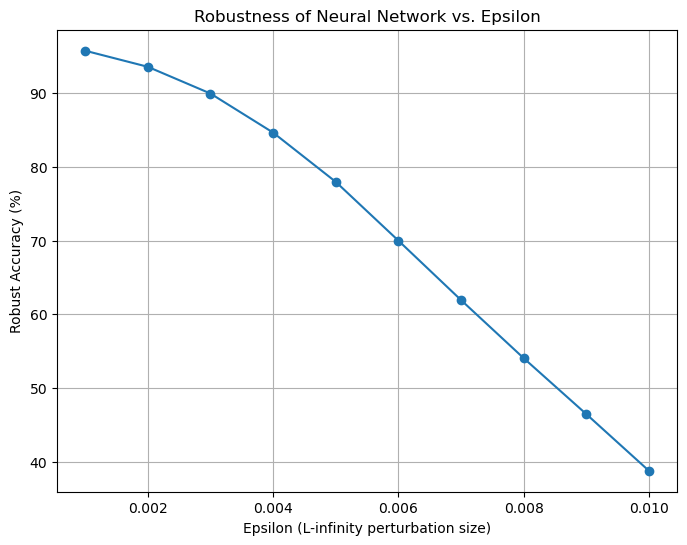

In [56]:
epsilon_values = np.linspace(0.001, 0.01, 10)

robust_accuracies = []
print("Measuring Robustness for epsilon in [.001,.002,.003,.004,.005,.006,.007,.008,.009,.01]")
for eps in epsilon_values:
    robust_acc = measure_robustness(model, test_loader, eps, device)
    robust_accuracies.append(robust_acc)
    print(f"Epsilon: {eps:.3f} - Robust Accuracy: {robust_acc:.2f}%")

plt.figure(figsize=(8,6))
plt.plot(epsilon_values, robust_accuracies, marker='o')
plt.title('Robustness of Neural Network vs. Epsilon')
plt.xlabel('Epsilon (L-infinity perturbation size)')
plt.ylabel('Robust Accuracy (%)')
plt.grid(True)
plt.show()


Measuring Robustness for epsilon in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]
Epsilon: 0.01 - Robust Accuracy: 38.820000000%
Epsilon: 0.02 - Robust Accuracy: 3.670000000%
Epsilon: 0.03 - Robust Accuracy: 0.150000000%
Epsilon: 0.04 - Robust Accuracy: 0.010000000%
Epsilon: 0.05 - Robust Accuracy: 0.000000000%
Epsilon: 0.06 - Robust Accuracy: 0.000000000%
Epsilon: 0.07 - Robust Accuracy: 0.000000000%
Epsilon: 0.08 - Robust Accuracy: 0.000000000%
Epsilon: 0.09 - Robust Accuracy: 0.000000000%
Epsilon: 0.10 - Robust Accuracy: 0.000000000%


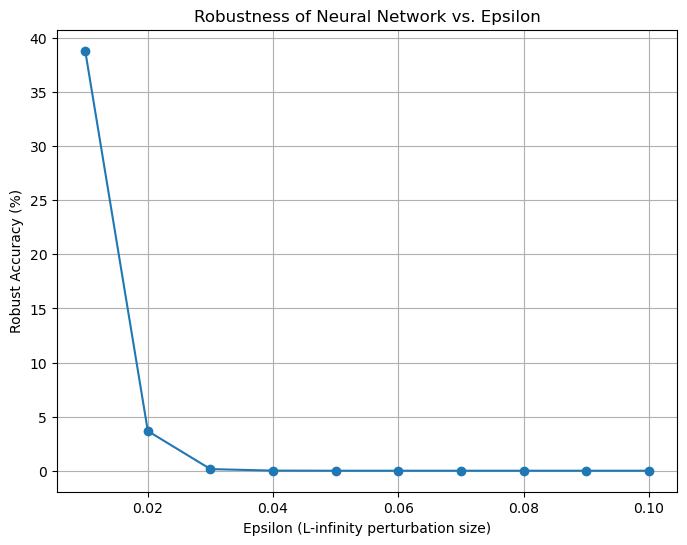

In [50]:
epsilon_values = np.linspace(0.01, 0.1, 10)
print("Measuring Robustness for epsilon in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]")
robust_accuracies = []
for eps in epsilon_values:
    robust_acc = measure_robustness(model, test_loader, eps, device)
    robust_accuracies.append(robust_acc)
    print(f"Epsilon: {eps:.2f} - Robust Accuracy: {robust_acc:.9f}%")

plt.figure(figsize=(8,6))
plt.plot(epsilon_values, robust_accuracies, marker='o')
plt.title('Robustness of Neural Network vs. Epsilon')
plt.xlabel('Epsilon (L-infinity perturbation size)')
plt.ylabel('Robust Accuracy (%)')
plt.grid(True)
plt.show()

#### Explanation

After measuring robustness on the 3-layer network for classifying images in the ImageNet dataset, I noticed that the model performs poorly in terms of robust accuracy. This is especially apparent when plotting epsilons in the range $[0.01, 0.1]$. We can see that after the initial $\epsilon = 0.01$, the performance quickly deteriorates.

To further investigate, I decided to measure the robust accuracy on epsilon values in the range $[0.001, 0.01]$. In this smaller range, we observe an improvement in robust accuracy, although this comes at much smaller perturbation ball sizes. 

These results make sense because the box method was employed to verify the network. The box method can be inaccurate, creating an estimation for the network that is too large and covers too many points not in the actual output of the neural network. 

Another important observation is that the network was never trained to be robust but only trained to be accurate. Further robust training could help the model achieve higher robust accuracy.


## Problem 3: Interpreting Neural Network Robustness Proofs

We have discussed various neural network verification techniques in the lectures. The proofs of robustness of neural networks generated by these techniques could, however, be uninterpretable for humans. Recent work [PROFIT](https://ggndpsngh.github.io/files/profit.pdf) addresses this issue and provides insights into the parts of neural networks important for robustness proofs. In this problem, we ask you to read the aforementioned paper and write a critical, conference-style review for it including the following parts:

1. **Summary:**  
   Summarize the paper in your own words.

2. **Strengths (at least 3):**  
   Elaborate on the strengths you see in the paper.

3. **Weaknesses (at least 3):**  
   Mention the weaknesses of this paper and suggest possible fixes for the same.

4. **Extensions (at least 1):**  
   Although such a section is not included in conference reviews, mention possible extensions of this work in the context of contemporary research.

**Fun fact:** This paper was the result of a course project in CS 521 - Fall 2022.

#### Answer


#### Summary
In the paper “Interpreting Robustness of Deep Neural Networks,” Banerjee et al. addressed a gap in DNN verification in the representation of robustness proofs. The paper aimed to address a gap in the human visualization techniques that exist for DNN robustness proofs. The paper introduced an algorithm that could identify important neurons in the penultimate layer of a DNN for a given robustness proof. This algorithm would iteratively reduce the number of important neurons until a final subset of neurons of high priority was selected. The paper showed how their technique is an improvement to a randomized algorithm as well as a gradient based algorithm for selecting important neurons for verifying the robustness of a DNN. The paper then showed how different models trained using different robustness techniques rely on a different subset of pixels to decide their classification. They showed that techniques that used provably robust trained networks filter out a lot of pixels that can be thought of as noise and not important whereas the robustness techniques that relied on adversarial generation relied more on pixels in the actual part of the image that as a human we use to classify the image. And algorithms that use a mixture of both techniques filter out pixels due to noise while preserving more of the actual structure’s pixels. 

#### Strengths
One strength of the paper is their Profit algorithm that is a novel and unique approach to identify important neurons in a neural network’s penultimate layer for verifying robustness. The paper’s pruning strategy in coming up with an upper bound for the priority of a neuron is what made their algorithm possible and was a great strength of the paper. The algorithm does a great job balancing size, efficiency and priority of the features in order to come up with a subset suitable for visualizing robustness proofs.

Another strength of the paper is its strong theoretical foundations. The paper rigorously proved their findings throughout such as the approximation of their priority metric. The paper provided robust definitions throughout making sure their statements weren’t unclear, ambiguous or not scientifically sound. Finally, the paper’s thoroughness in proving the theoretical correctness of their Profit algorithm is a great strength of the paper. 

The paper’s experimental analysis was a great strength as well. The paper used robustness training techniques using adversarial generation, proof based and a combination of the two to show how they affect a model. The paper showed how these different techniques change the interpretability of a model’s prediction and what pixels are used to determine image classification. 

I’d also like to mention that the paper’s inclusion of their code in a publicly accessible GitHub repository is great for the community and great for building upon the paper. 

#### Weakness
One weakness of the paper is that the Profit method can’t scale to larger networks. The method is based upon DNN verifiers and currently there doesn’t exist efficient enough algorithms to verify large networks. Possible fixes for this issue are coming up with more efficient robustness verifiers that are capable of scaling to larger networks, although this is difficult. Another approach could be to make the method of finding neurons that contribute the most to robustness not dependent on the verifiers themselves. 

The paper also focused on neurons only in the penultimate layer which severely limits the Profit algorithm’s ability to find important features from other layers. Extending the paper’s approach to other layers while coming up with an algorithm for determining how far you should go would add to the strength of the paper. There could be some type of hierarchical feature analysis involving more layers. 

The paper primarily focused on MNIST and CIFAR-10 datasets when carrying out experiments while using specific network architectures. This could limit the generalizability of the findings to other datasets, more complex architectures or other domains. A possible fix is to expand the paper’s experimental section to include other datasets, different model architectures and possibly other domains. 

#### Extension
One exciting way the paper could be extended is by using the ProFIt algorithm from the paper to enhance model efficiency during inference by identifying and utilizing only the most critical neurons by using ProFit to dynamically prune ineffective neurons. By extending the priority metric used in ProFIt which measures each neuron's importance, in the penultimate layer, based on its impact on the robustness proof we can determine which neurons contribute most significantly to both performance and robustness. This could also introduce another strategy for maintaining robustness by not letting spurious neuron’s affect the output of the model. By pruning neurons with lower priority we would reduce the model's complexity and computational load during inference making the model more efficient while also balancing robustness and accuracy. 
